# REACHING_TASK --> Use this kernal

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os,sys,glob, json
import _pickle as pkl
import dlab
from tqdm.notebook import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use('dark_background')


### Make sure you use version 2.2.0 of pynwb
- pip uninstall pynwb
- pip install pynwb==2.2.0

In [2]:
import pynwb
print(pynwb.__version__)

2.3.3


# Paths needed to be changed to your own paths

In [77]:
probe_names = ['A', 'B', 'C', 'D', 'E']
NP_type=['NP1','NP1','NP2','NP1','NP1']
probedepths = [4156, 7013, 1450, 4878, 6202]

In [3]:
file_name = 'reach7_07_2024-12-04_20-57-49_008'
root_recording_folder = fr"G:\Grant\neuropixels\kilosort_recordings\{file_name}"

In [4]:

recording_folder = root_recording_folder + r"\Record Node 103\experiment1\recording1\continuous"
if not os.path.exists(recording_folder):
    raise FileNotFoundError(f"Recording folder not found: {recording_folder}")
else:
    print("Recording folder found: ", recording_folder)

Recording folder found:  G:\Grant\neuropixels\kilosort_recordings\reach7_07_2024-12-04_20-57-49_008\Record Node 103\experiment1\recording1\continuous


##### Find the behavior files from the recording folder
- if threy are not found, you will need to manually specify the behavior file paths

In [5]:
root_behavior_path = r'Z:\PHYS\ChristieLab\Lab Management\Grant\reaching_data\compressed_data\Reach7\20241204\christielab\session006'
date = '20241204'
session_num = 'session006'

In [6]:
frontCam_events_txt = root_behavior_path + '\\' + date + '_christielab_' + session_num + '_events.txt'
frontCam_timestamps = root_behavior_path + '\\' + date + '_christielab_' + session_num + '_frontCam_timestamps.txt'
stim_frame_path = root_behavior_path + '\\' + date + '_christielab_' + session_num + '_sideCam_timestamps.txt'

if not os.path.exists(frontCam_events_txt):
    raise FileNotFoundError("FrontCam events txt file not found")
if not os.path.exists(frontCam_timestamps):
    raise FileNotFoundError("FrontCam timestamps txt file not found")
if not os.path.exists(stim_frame_path):
    raise FileNotFoundError("Stimulus frame txt file not found")
else:
    print("All Behavior files found")


All Behavior files found


#### Create a file name for the NWB file
- if an NWB already exists for this session, a new NWB file will be created with a timestamp added to the file name, so you dont over write the old file"

In [7]:
# THIS SHOULD NOT just point to the folder, but needs to include the name you want the nwb file to be called /nwb_file_name
nwb_save_path = fr"G:\Grant\neuropixels\nwb\{file_name}"

if not os.path.exists(nwb_save_path):
    print("Now NWB file found with this name, creating it now: ", nwb_save_path)
else:
    print("NWB save file already exists, saving you from overwriting your data by adding a timestamp to the end of the file name")
    nwb_save_path = nwb_save_path +'__' + dt.datetime.now().strftime("_%Y-%m-%d_%H-%M-%S")

print("NWB file will be saved as: ", nwb_save_path)

Now NWB file found with this name, creating it now:  G:\Grant\neuropixels\nwb\reach7_07_2024-12-04_20-57-49_008
NWB file will be saved as:  G:\Grant\neuropixels\nwb\reach7_07_2024-12-04_20-57-49_008


#### Create directories for reach event data to save to

In [8]:
reach_event_save_path = root_recording_folder+ '\\all_reach_events'
full_reach_event_save_path = root_recording_folder+ '\\full_reach_events'

# Careful as this will plot all the reaches in the recording, if you have a long recording this will take a long time
if not os.path.exists(reach_event_save_path):
    os.makedirs(reach_event_save_path)
    print('Directory created: , ', reach_event_save_path)
else:
    print('Directory already exists: ', reach_event_save_path)

if not os.path.exists(full_reach_event_save_path):
    os.makedirs(full_reach_event_save_path)
    print('Directory created: ', full_reach_event_save_path)
else:
    print('Directory already exists: ', full_reach_event_save_path)

Directory already exists:  G:\Grant\neuropixels\kilosort_recordings\reach7_07_2024-12-04_20-57-49_008\all_reach_events
Directory already exists:  G:\Grant\neuropixels\kilosort_recordings\reach7_07_2024-12-04_20-57-49_008\full_reach_events


In [9]:
#recording_folder = root_recording_folder
stim_path = frontCam_events_txt
frame_path = frontCam_timestamps
#nwb_path = save_path_nwb

### Load in raw recording data

In [10]:
recording_folder = root_recording_folder
# recording_folder = r'G:/Grant/rotation/2023-09-29_16-07-39_PaBont2'

experimenter = 'grh'
experiment_description= 'Christie Lab, University of Colorado Anschutz. Reaching  task with Pontine Gray mossy fiber stimulation to induce learning. Mouse used Reach7, was a Niave Mouse that could reach with ~80% success rate. recorded with 5 neuropixels (four NP1, and one NP2-4-shank in MoP ) from (SIM&IP, PG, MoP, VaL, SnR) with (probe_A, Probe_B, and Probe_C, Probe_D and Probe_E) respectively'

# #spikeglx
# probes = [os.path.basename(f) for f in np.sort(glob.glob(recording_folder+'/*-AP*'))]

probeids = ['A', 'B','C','D','E'] 

# Use MPM-relative probe depths (in microns)
probedepths = [4156,7013,1450,4878,6202] 

### Read in .txt files with event times logged as frame numbers

In [11]:
from collections import defaultdict
import time

# Initialize defaultdicts
data = defaultdict(list)

# Measure time for file processing
start_time = time.time()

# Open and read the file
with open(stim_path, 'r') as file:
    lines = file.readlines()

# Parse the data
for line in lines:
    parts = line.strip().split('\t')
    if len(parts) == 2:
        name, value = parts
        data[name].append(int(value))

print("File parsing completed in:", time.time() - start_time, "seconds")

# Access data directly
pellet_detected_frame = data['pellet_detected']
pellet_delivery_frame = data['pellet_delivery']
T5000_frame = data['T5000_played']
T6000_frame = data['T6000_played']

# Print summaries
print("Pellet Detected (First 5):", pellet_detected_frame[:5])
print("Total Detected Values:", len(pellet_detected_frame))
print("Pellet Delivery (First 5):", pellet_delivery_frame[:5])
print("Total Delivery Values:", len(pellet_delivery_frame))
print("T5000 Values (First 5):", T5000_frame[:5])
print("Total T5000 Values:", len(T5000_frame))
print("T6000 Values (First 5):", T6000_frame[:5])
print("Total T6000 Values:", len(T6000_frame))

# Divide each value by 150
pellet_detected_seconds = [v / 150 for v in pellet_detected_frame]
pellet_delivery_seconds = [v / 150 for v in pellet_delivery_frame]

print("\nPellet Detected (First 5 in Seconds):", pellet_detected_seconds[:5])
print("Pellet Delivery (First 5 in Seconds):", pellet_delivery_seconds[:5])

# Slow motion factor
slow_motion_factor = 4.994614744995619

pellet_delivery_slow_motion = [t * slow_motion_factor for t in pellet_delivery_seconds]
pellet_detected_slow_motion = [t * slow_motion_factor for t in pellet_detected_seconds]

print("\nPellet Detected Aligned to Slow Motion Video (First 5):", pellet_detected_slow_motion[:5])
print("Pellet Delivery Aligned to Slow Motion Video (First 5):", pellet_delivery_slow_motion[:5])

# Convert to minutes
detected_slowmo_minutes_array = [seconds / 60 for seconds in pellet_detected_slow_motion]
delivery_slowmo_minutes_array = [seconds / 60 for seconds in pellet_delivery_slow_motion]

print("\nPellet Detected (Slow Motion in Minutes - First 5):", detected_slowmo_minutes_array[:5])
print("Pellet Delivery (Slow Motion in Minutes - First 5):", delivery_slowmo_minutes_array[:5])


File parsing completed in: 0.027347087860107422 seconds
Pellet Detected (First 5): [2806, 4982, 7193, 9443, 11618]
Total Detected Values: 205
Pellet Delivery (First 5): [2731, 4906, 7118, 9369, 11544]
Total Delivery Values: 216
T5000 Values (First 5): [2733, 4908, 7120, 9372, 11546]
Total T5000 Values: 216
T6000 Values (First 5): [2608, 4819, 7032, 9282, 11457]
Total T6000 Values: 219

Pellet Detected (First 5 in Seconds): [18.706666666666667, 33.21333333333333, 47.95333333333333, 62.95333333333333, 77.45333333333333]
Pellet Delivery (First 5 in Seconds): [18.206666666666667, 32.70666666666666, 47.45333333333333, 62.46, 76.96]

Pellet Detected Aligned to Slow Motion Video (First 5): [93.4325931630514, 165.88780439712116, 239.5084257383566, 314.4276469132909, 386.84956071572736]
Pellet Delivery Aligned to Slow Motion Video (First 5): [90.93528579055358, 163.35719959299004, 237.01111836585878, 311.9636369724264, 384.38555077486285]

Pellet Detected (Slow Motion in Minutes - First 5): [1.

##### verify the numbe of events 

In [12]:
print("total Detected Values:", len(pellet_detected_frame))
print("total Delivery Values:", len(pellet_delivery_frame))
print("total T5000 Values:", len(T5000_frame))
print("total T6000 Values:", len(T6000_frame))

total Detected Values: 205
total Delivery Values: 216
total T5000 Values: 216
total T6000 Values: 219


### load in .txt file containing each frame number. stored as time between frame in nano-seconds

In [13]:
import time

# Initialize variables
frames = []

# Measure time for file reading
start_time = time.time()

# Open and read the text file
with open(stim_frame_path, 'r') as file:
    frames = [int(line.strip()) for line in file]

print("File parsing completed in:", time.time() - start_time, "seconds")

# Summarize frames
print("Total Frames:", len(frames))
print("First 5 Frames:", frames[:5])

# Compute frame numbers and related time metrics
frame_numbers = [(index + 1) / 150 for index in range(len(frames))]
frames_txt_file = [index + 1 for index in range(len(frames))]

# Print results
print("\nFrame Numbers (First 5):", frame_numbers[:5])
print("Recording Time (Seconds):", len(frame_numbers) / 150)
print("Recording Time (Minutes):", len(frame_numbers) / 150 / 60)


File parsing completed in: 0.14816904067993164 seconds
Total Frames: 726963
First 5 Frames: [6667248, 6668080, 6667000, 6666704, 6667320]

Frame Numbers (First 5): [0.006666666666666667, 0.013333333333333334, 0.02, 0.02666666666666667, 0.03333333333333333]
Recording Time (Seconds): 4846.42
Recording Time (Minutes): 80.77366666666667


In [14]:
frame_path = frontCam_timestamps
# Initialize an empty list to store the numbers
frames = []

# Open and read the text file
with open(frame_path, 'r') as file:
    for line in file:
        number = int(line.strip())
        frames.append(number)

# Now, 'numbers' is a list containing all the numbers from the text file
print("Numbers Array:", frames[0:5])
print("total frames: ", len(frames))

# frame_numbers = [index + 1 for index in range(len(frames))]
frame_numbers = [(index + 1) / 150 for index in range(len(frames))]
frames_txt_file = [(index + 1) for index in range(len(frames))]



print('frame numbers: ', frame_numbers[0:5])
print('Recording Time Seconds:', len(frame_numbers)/150)
print('Recording Time Minutes:', len(frame_numbers)/150 / 60)





Numbers Array: [6667112, 6667592, 6666760, 6667920, 6666344]
total frames:  726965
frame numbers:  [0.006666666666666667, 0.013333333333333334, 0.02, 0.02666666666666667, 0.03333333333333333]
Recording Time Seconds: 4846.433333333333
Recording Time Minutes: 80.77388888888889


### Plot the time between each frame, to see drop frames
- each big blue spike is a droppe frame (womp womp)

total frame timestamps: 726965
recording duration seconds: 4846.433333333333
recording duration minutes: 80.77388888888889


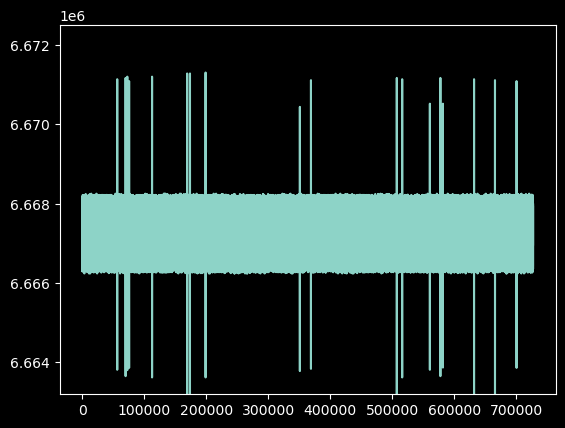

In [15]:
txt_file_frame_count = len(frames)
print("total frame timestamps:", txt_file_frame_count)
print("recording duration seconds:", txt_file_frame_count/150)
print("recording duration minutes:", txt_file_frame_count/150/60)
plt.ylim(6663200, 6672500)
plt.plot((frames))



### Load in the events data, logged in the digial lines of the openephys aquisition. and stored in the events folder of your recording

In [16]:
from open_ephys.analysis import Session

directory = recording_folder # for example
directory = root_recording_folder # for example


session = Session(directory)
print(f'session: {session}')


session: 
Open Ephys Recording Session Object
Directory: G:\Grant\neuropixels\kilosort_recordings\reach7_07_2024-12-04_20-57-49_008

<object>.recordnodes:
  Index 0: Record Node 103 (binary format)



In [17]:
session.recordnodes[0].recordings[0].events
session.recordnodes[0].recordings[0].events

,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
0,1,610364,244.002726,100,3,ProbeB-LFP,0
1,1,610369,244.002729,100,1,ProbeA-LFP,0
2,1,7324428,244.002733,100,0,ProbeA-AP,0
3,1,610362,244.002735,100,6,ProbeD-LFP,0
4,1,7324369,244.002736,100,2,ProbeB-AP,0
...,...,...,...,...,...,...,...
833192,1,13294262,5317.560000,100,1,ProbeA-LFP,1
833193,1,13294028,5317.560039,100,8,ProbeE-LFP,1
833194,1,159528341,5317.560075,100,7,ProbeE-AP,1
833195,1,159529481,5317.560237,100,5,ProbeD-AP,1


In [18]:
events_df = pd.DataFrame(session.recordnodes[0].recordings[0].events)


# Speical global_timestamps df 
- this is used ONLY if your timestamps get messed up due to a syncronization issue during the recording, otherwise do not run the cell bellow
#### Here are the steps to make a global_timestamps df if our data is messed up
- use the manually_align_timestamps.ipynb file 

In [19]:
# global_timestamps_df = r"G:\Grant\neuropixels\kilosort_recordings\reach3_01_2024-11-14_21-30-18_001\Record Node 103\experiment1\recording1\events\global_timestamps\global_timestamps_overwrite.csv"
# events_df = pd.read_csv(global_timestamps_df)
# events_df

### Verify all event types are being recorded

In [20]:
probeA_AP = events_df[events_df.stream_name == 'ProbeA-AP' ]
probeA_AP

,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
2,1,7324428,244.002733,100,0,ProbeA-AP,0
13,1,7339428,244.502733,100,0,ProbeA-AP,1
28,1,7354429,245.002767,100,0,ProbeA-AP,0
34,1,7369429,245.502767,100,0,ProbeA-AP,1
45,1,7384429,246.002767,100,0,ProbeA-AP,0
...,...,...,...,...,...,...,...
833147,1,159471146,5315.559654,100,0,ProbeA-AP,1
833165,1,159486147,5316.060033,100,0,ProbeA-AP,0
833167,1,159501147,5316.559687,100,0,ProbeA-AP,1
833184,1,159516147,5317.060033,100,0,ProbeA-AP,0


In [21]:
probeA_AP = events_df[events_df.stream_name == 'ProbeA-AP' ]
probeB_AP = events_df[events_df.stream_name == 'ProbeB-AP' ]
probeC_AP = events_df[events_df.stream_name == 'ProbeC' ]
probeD_AP = events_df[events_df.stream_name == 'ProbeD-AP' ]
probeE_AP = events_df[events_df.stream_name == 'ProbeE-AP' ]


In [22]:
ni_df = events_df[events_df.stream_name == 'PXIe-6341' ]
ni_df

,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
12,7,9796405,244.502731,102,9,PXIe-6341,1
27,7,9816405,245.002746,102,9,PXIe-6341,0
38,7,9836405,245.502785,102,9,PXIe-6341,1
39,7,9856404,246.002751,102,9,PXIe-6341,0
52,7,9876404,246.502766,102,9,PXIe-6341,1
...,...,...,...,...,...,...,...
833151,7,212632632,5315.559944,102,9,PXIe-6341,1
833160,7,212652631,5316.059934,102,9,PXIe-6341,0
833171,7,212672631,5316.559949,102,9,PXIe-6341,1
833180,7,212692630,5317.059939,102,9,PXIe-6341,0


### SideCam Frame numbers are recorded in the events folder on digital line 8, and the rest of the digial lines are made into veraibles below 
- Digital Line 8

In [23]:
frame_events = ni_df[ni_df['line'] == 8]
frame_events


,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
79,8,9923577,247.682126,102,9,PXIe-6341,1
80,8,9923843,247.688777,102,9,PXIe-6341,0
81,8,9924111,247.695477,102,9,PXIe-6341,1
82,8,9924376,247.702102,102,9,PXIe-6341,0
83,8,9924644,247.708802,102,9,PXIe-6341,1
...,...,...,...,...,...,...,...
826382,8,203826252,5095.393865,102,9,PXIe-6341,0
826383,8,203826520,5095.400565,102,9,PXIe-6341,1
826384,8,203826786,5095.407215,102,9,PXIe-6341,0
826385,8,203827054,5095.413915,102,9,PXIe-6341,1


### Sync pulse is recorded on digital line 7, every half second
- Digital line 7

In [24]:
sync_pulse_events = ni_df[ni_df['line'] == 7]
sync_pulse_events


,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
12,7,9796405,244.502731,102,9,PXIe-6341,1
27,7,9816405,245.002746,102,9,PXIe-6341,0
38,7,9836405,245.502785,102,9,PXIe-6341,1
39,7,9856404,246.002751,102,9,PXIe-6341,0
52,7,9876404,246.502766,102,9,PXIe-6341,1
...,...,...,...,...,...,...,...
833151,7,212632632,5315.559944,102,9,PXIe-6341,1
833160,7,212652631,5316.059934,102,9,PXIe-6341,0
833171,7,212672631,5316.559949,102,9,PXIe-6341,1
833180,7,212692630,5317.059939,102,9,PXIe-6341,0


### TTL created when paw passes through stimulus ROI and the mean luminance is above threshold
- Digital line 6

In [25]:
stimROI_events = ni_df[ni_df['line'] == 6]
stimROI_events


,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
84,6,9924705,247.710327,102,9,PXIe-6341,1
85,6,9924905,247.715327,102,9,PXIe-6341,0
3275,6,10675426,266.478939,102,9,PXIe-6341,1
3276,6,10675627,266.483964,102,9,PXIe-6341,0
5700,6,11243198,280.673692,102,9,PXIe-6341,1
...,...,...,...,...,...,...,...
813626,6,200828436,5020.446225,102,9,PXIe-6341,0
818476,6,201968310,5048.943927,102,9,PXIe-6341,1
818477,6,201968510,5048.948927,102,9,PXIe-6341,0
820994,6,202558230,5063.692367,102,9,PXIe-6341,1


### TTL for tone1 (T5000) 
- Digital line 5

In [26]:
tone1_events = ni_df[ni_df['line'] == 5]
tone1_events.head()
tone1_events

,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
3038,5,10618561,265.057246,102,9,PXIe-6341,1
3039,5,10618759,265.062196,102,9,PXIe-6341,0
5545,5,11208394,279.803539,102,9,PXIe-6341,1
5547,5,11208591,279.808464,102,9,PXIe-6341,0
8064,5,11798546,294.557752,102,9,PXIe-6341,1
...,...,...,...,...,...,...,...
813533,5,200806798,5019.905259,102,9,PXIe-6341,0
818383,5,201946826,5048.407304,102,9,PXIe-6341,1
818385,5,201947023,5048.412229,102,9,PXIe-6341,0
820853,5,202526538,5062.900044,102,9,PXIe-6341,1


### Each event is a single light pulse that goes out the optical fiber. these timestamps are the time the light pulse was sent out. it tells you nothing about the duration of each pulse
- Digital line 4

In [27]:
optical_events = ni_df[ni_df['line'] == 4]
optical_events

,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
108486,4,35389461,884.348338,102,9,PXIe-6341,1
108488,4,35389661,884.353338,102,9,PXIe-6341,0
108491,4,35389861,884.358338,102,9,PXIe-6341,1
108493,4,35390061,884.363339,102,9,PXIe-6341,0
108495,4,35390261,884.368339,102,9,PXIe-6341,1
...,...,...,...,...,...,...,...
833122,4,212586515,5314.406465,102,9,PXIe-6341,0
833123,4,212586915,5314.416466,102,9,PXIe-6341,1
833124,4,212587315,5314.426466,102,9,PXIe-6341,0
833125,4,212587715,5314.436466,102,9,PXIe-6341,1


### This is just Tone2 (T6000), (ie. when pellet was revealed)
- Digital line 3

In [28]:
tone2_events = ni_df[ni_df['line'] == 3]
tone2_events

,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
3175,3,10652041,265.894271,102,9,PXIe-6341,1
3177,3,10652238,265.899196,102,9,PXIe-6341,0
5646,3,11232114,280.396529,102,9,PXIe-6341,1
5648,3,11232311,280.401454,102,9,PXIe-6341,0
8164,3,11822066,295.145770,102,9,PXIe-6341,1
...,...,...,...,...,...,...,...
813637,3,200830597,5020.500252,102,9,PXIe-6341,0
818485,3,201970346,5048.994828,102,9,PXIe-6341,1
818487,3,201970543,5048.999753,102,9,PXIe-6341,0
821004,3,202560378,5063.746069,102,9,PXIe-6341,1


# Sort the global_timestamps dataframe by the 'global_timestamps' column
- required for some reason

In [29]:
frame_events = frame_events.sort_values(by="timestamp", ascending=True)
sync_pulse_events = sync_pulse_events.sort_values(by="timestamp", ascending=True)
tone1_events = tone1_events.sort_values(by="timestamp", ascending=True)
tone2_events = tone2_events.sort_values(by="timestamp", ascending=True)
stimROI_events = stimROI_events.sort_values(by="timestamp", ascending=True)
optical_events = optical_events.sort_values(by="timestamp", ascending=True)


In [30]:
probeA_AP = probeA_AP.sort_values(by="timestamp", ascending=True)
probeB_AP = probeB_AP.sort_values(by="timestamp", ascending=True)
probeC_AP = probeC_AP.sort_values(by="timestamp", ascending=True)
probeD_AP = probeD_AP.sort_values(by="timestamp", ascending=True)
probeE_AP = probeE_AP.sort_values(by="timestamp", ascending=True)

In [31]:
probeA_AP

,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
2,1,7324428,244.002733,100,0,ProbeA-AP,0
13,1,7339428,244.502733,100,0,ProbeA-AP,1
28,1,7354429,245.002767,100,0,ProbeA-AP,0
34,1,7369429,245.502767,100,0,ProbeA-AP,1
45,1,7384429,246.002767,100,0,ProbeA-AP,0
...,...,...,...,...,...,...,...
833147,1,159471146,5315.559654,100,0,ProbeA-AP,1
833165,1,159486147,5316.060033,100,0,ProbeA-AP,0
833167,1,159501147,5316.559687,100,0,ProbeA-AP,1
833184,1,159516147,5317.060033,100,0,ProbeA-AP,0


### This cell is old and splits the data in half, but i now know the data is not split in half evenly. sometimes tone1 goes off and no tone2 goes off

In [32]:
# extract every 2nd value from the array and make it a new array, do the same for the other array
# tone1_events = tone1_2_events.iloc[::2, :]
# tone2_events = tone2_events.iloc[1::2, :]

#### extract the timestamps from the rows for each events dataframe  
- get array of the synchronized timestamps for all digital events

In [33]:
# frame_timestamps = frame_events['timestamp'].values
# print(f'goal: {60/150}')
# print(f'frames count {len(frame_timestamps)}')
# print(f'frame: {len(frame_timestamps)/150}')
# frame_timestamps[6] - frame_timestamps[1]

In [34]:
# Digital Line 8
frame_timestamps = frame_events['timestamp'].values

# Digital Line 7
sync_pulse_timestamps = sync_pulse_events['timestamp'].values
sync_pulse_timestamps = sync_pulse_timestamps[0::2]

# Digital Line 6
stimROI_timestamps  = stimROI_events['timestamp'].values
stimROI_timestamps = stimROI_timestamps[0::2]

# Digital Line 5
tone1_timestamps = tone1_events['timestamp'].values
tone1_timestamps = tone1_timestamps[0::2]

# Digital Line 4
optical_timestamps = optical_events['timestamp'].values

# Digital Line 4 --> (every 10th value)
first_optical_timestamp_per_event = optical_events['timestamp'].values
first_optical_timestamp_per_event = first_optical_timestamp_per_event[1::10]

# Digital Line 3 (NEED TO SET THIS UP FROM BUTTON)
tone2_timestamps  = tone2_events['timestamp'].values
tone2_timestamps = tone2_timestamps[0::2]


### Check that the timestamps are correct
- first part, check the total number of timestamps make sense
- Second part, check that the logic of the time stamps makes sense

In [35]:
print('Part 1: ')
print('frame timestamps:', len(frame_events))
print('sync_pulse timestamps:', len(sync_pulse_timestamps)) # 1hz
print('tone1 timestamps:', len(tone1_timestamps))
print('tone2 timestamps:', len(tone2_timestamps))
print('stimROI timestamps:', len(stimROI_timestamps))
print('optical timestamps:', len(optical_timestamps))
print('')
print('Part 2: ')
print('behavior video duration (min) using frames: ', round((len(frame_timestamps) / 150 / 60), 2))
print('open-ephys recording duration (min) using sync pulses: ', round((len(sync_pulse_timestamps) / 60), 2))
print('frame rate of camera (Value should be close to 150): ', round(len(frame_timestamps) / len(sync_pulse_timestamps), 2))
print('Avg time between frames (Goal is 0.40): ', round(np.mean(np.diff(frame_timestamps)) * 100, 2))
print('Avg time between sync pulses (Goal is 1.0): ', round(np.mean(np.diff(sync_pulse_timestamps)), 2))
print('Avg time between stimROI (should be roughly 15-20 seconds apart): ', round(np.mean(np.diff(stimROI_timestamps)), 2))
print('Avg time between first optical pulses (should be roughly identical to the value above for Avg time between stimROI): ', round(np.mean(np.diff(first_optical_timestamp_per_event)), 2))





Part 1: 
frame timestamps: 727088
sync_pulse timestamps: 5074
tone1 timestamps: 219
tone2 timestamps: 216
stimROI timestamps: 200
optical timestamps: 3360

Part 2: 
behavior video duration (min) using frames:  80.79
open-ephys recording duration (min) using sync pulses:  84.57
frame rate of camera (Value should be close to 150):  143.3
Avg time between frames (Goal is 0.40):  0.67
Avg time between sync pulses (Goal is 1.0):  1.0
Avg time between stimROI (should be roughly 15-20 seconds apart):  24.2
Avg time between first optical pulses (should be roughly identical to the value above for Avg time between stimROI):  13.22


#### Verify the duration of the recording, and the number of frames in the recording
- this should be the duration of the behavior video, not the full open-ephys recording duration. 
- because the open-ephys recording has baseline, opto-tagging, and other things making it longer

In [36]:
## Value should be 150, as the frame rate is 150 Hz, and the video was roughly 120 scoonds long
duration_of_video = 80 # in minutes

Behavior_video_length = duration_of_video * 60 # in seconds
print('value should be close to (150) because 150hz frame rate: ',len(frame_timestamps) / Behavior_video_length)

## Value is the duration of the behavior recording in minutes, because the frame rate is 150 Hz
print(len(frame_timestamps)/Behavior_video_length/60)


value should be close to (150) because 150hz frame rate:  151.47666666666666
2.524611111111111


#### Verify the time between the StimROI and the frame in which you saw light on the camera
- the Difference between Stim TTL & the first frame with an optical pusle seen should be less that 1.0ms

In [37]:
# light_seen_frame = [940,3985,6181,8418,11143,15432]
# stim_number = 0

# for i in light_seen_frame:

#     first_light_frame_vs_StimTTL_difference = (stimROI_timestamps[stim_number] -  frame_timestamps[i]) *100

#     print('stim number:', stim_number+1)
#     print(f'stimROI TTL timestamps Vs. timestamp of frame with first optical pulse: ', stimROI_timestamps[stim_number].round(2),frame_timestamps[i].round(2))
#     print(f'Difference between Stim TTL & the first frame with an optical pusle seen: ', first_light_frame_vs_StimTTL_difference.round(2))
#     print('')
    
#     stim_number += 1
    

#### Validate the time between tone2 and the optical times are small

### Plot tone1, tone2, stimROI, and optical timestamps

In [38]:
tone1_timestamps[0],tone2_timestamps[0], stimROI_timestamps[0], optical_timestamps[0]

(265.0572456559737, 265.8942706686352, 247.71032728126445, 884.3483381777169)

## Plot events to see if they are aligned

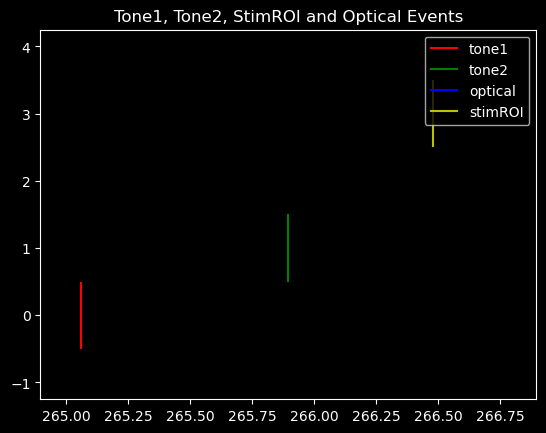

In [39]:
# Check one single event / reach
plt.eventplot([tone1_timestamps,tone2_timestamps, optical_timestamps,stimROI_timestamps], orientation='horizontal', colors=['r','g','b','y'])
plt.xlim(tone2_timestamps[0]-1, tone2_timestamps[0]+1)
plt.legend(['tone1','tone2', 'optical','stimROI'])
plt.title('Tone1, Tone2, StimROI and Optical Events')
plt.show()


## Create a plot for every reach
- this saves the plots showing the timeing of the events as recorded by the digital board 
- plots are saved too the reach_event_save_path and full_reach_event_save_path (both paths are automatically created at the start of this 01_makeNWB.ipynb file, and should be in the root recording foler)

In [41]:
import pandas as pd
df = pd.DataFrame(T6000_frame)
# df.to_csv (T6000_frame_path, index = None, header=True)

In [42]:
reach_event_save_path_02 = reach_event_save_path + '\\2_combined_reach_events'

if reach_event_save_path_02+f'\\reach_1.png' in glob.glob(reach_event_save_path_02+f'\\reach_*.png'):
    print('Files / plots already exist')
    print('either delete the plots or change the save path')
    
else:
    if not os.path.exists(reach_event_save_path_02):
        os.makedirs(reach_event_save_path_02)
        print('Directory created: ', reach_event_save_path_02)
        
    fig, axs = plt.subplots(nrows=2,ncols=1, figsize=(8,6))

    for i in range(len(tone1_timestamps)):
        
        axs[0].eventplot([tone1_timestamps, tone2_timestamps, optical_timestamps,stimROI_timestamps], orientation='horizontal', colors=['r', 'g','b','y'])
        axs[0].set_xlim(tone1_timestamps[i]-3.5, tone1_timestamps[i]+3.5)
        axs[0].legend(['tone1','tone2', 'optical','stimROI'])
        axs[0].set_title(f' Reach Number: {i+1} \n T6000_frame_number: {T6000_frame[i]}')

        axs[1].eventplot([tone1_timestamps, tone2_timestamps, optical_timestamps,stimROI_timestamps], orientation='horizontal', colors=['r', 'g','b','y'])
        axs[1].set_xlim(tone1_timestamps[i]-12.5, tone1_timestamps[i]+12.5)
        axs[1].legend(['tone1','tone2', 'optical','stimROI'])
        axs[1].set_title(f' Reach Number: {i+1} \n T6000_frame_number: {T6000_frame[i]}')

        plt.tight_layout()

        plt.savefig(reach_event_save_path_02+f'\\reach_{i}.png')

Files / plots already exist
either delete the plots or change the save path


In [43]:
reach_event_save_path_03 = reach_event_save_path + '\\3_combined_reach_events'

if reach_event_save_path_03+f'\\reach_1.png' in glob.glob(reach_event_save_path_03+f'\\reach_*.png'):
    print('Files / plots already exist')
    print('either delete the plots or change the save path')

else:
    if not os.path.exists(reach_event_save_path_03):
        os.makedirs(reach_event_save_path_03)
        print('Directory created: ', reach_event_save_path_03)
    fig, axs = plt.subplots(nrows=3,ncols=1, figsize=(6,10))

    for i in range(len(tone1_timestamps)):
        
        axs[0].eventplot([tone1_timestamps, tone2_timestamps, optical_timestamps,stimROI_timestamps], orientation='horizontal', colors=['r', 'g','b','y'])
        axs[0].set_xlim(tone1_timestamps[i]-3.5, tone1_timestamps[i]+3.5)
        axs[0].legend(['tone1','tone2', 'optical','stimROI'])
        axs[0].set_title(f' Reach Number: {i+1} \n T6000_frame_number: {T6000_frame[i]}')

        axs[1].eventplot([tone1_timestamps, tone2_timestamps, optical_timestamps,stimROI_timestamps], orientation='horizontal', colors=['r', 'g','b','y'])
        axs[1].set_xlim(tone1_timestamps[i]-12.5, tone1_timestamps[i]+12.5)
        axs[1].legend(['tone1','tone2', 'optical','stimROI'])
        axs[1].set_title(f' Reach Number: {i+1} \n T6000_frame_number: {T6000_frame[i]}')

        axs[2].eventplot([tone1_timestamps, tone2_timestamps, optical_timestamps,stimROI_timestamps], orientation='horizontal', colors=['r', 'g','b','y'])
        axs[2].set_xlim(tone1_timestamps[i]-20, tone1_timestamps[i]+20)
        axs[2].legend(['tone1','tone2', 'optical','stimROI'])
        axs[2].set_title(f' Reach Number: {i+1} \n T6000_frame_number: {T6000_frame[i]}')

        plt.tight_layout()

        plt.savefig(reach_event_save_path_03+f'\\reach_{i}.png')

Files / plots already exist
either delete the plots or change the save path


In [44]:
# if reach_event_save_path+f'\\reach_1.png' in glob.glob(reach_event_save_path+f'\\reach_*.png'):
#     print('Files already exists')
# else:
#     for i in range(len(tone1_timestamps)):
#         plt.eventplot([tone1_timestamps, tone2_timestamps, optical_timestamps,stimROI_timestamps], orientation='horizontal', colors=['r', 'g','b','y'])
#         #plt.xlim(tone1_timestamps[i]-2, tone2_timestamps[i]+2)
#         plt.xlim(tone1_timestamps[i]-2, tone1_timestamps[i]+3)
#         plt.legend(['tone1','tone2', 'optical','stimROI'])
#         plt.title('Tone2 and Optical Events')
#         plt.savefig(reach_event_save_path+f'\\reach_{i}.png')

        
#     for i in range(len(tone1_timestamps)):
#         plt.eventplot([tone1_timestamps, tone2_timestamps, optical_timestamps,stimROI_timestamps], orientation='horizontal', colors=['r', 'g','b','y'])
#         plt.xlim(tone1_timestamps[i]-10, tone2_timestamps[i]+10)
#         plt.legend(['tone1','tone2', 'optical','stimROI'])
#         plt.title('Tone2 and Optical Events')
#         plt.savefig(full_reach_event_save_path+f'\\reach_{i}.png')



## End of plotting 

### using the number of rows recorded in the frame_events dataframe, we can calculate the total number of frames recorded, since each row is equivalent to one frame. we can use this to find total recording duration in seconds

In [45]:
row_numbers = np.arange(1, len(ni_df[ni_df['line'] == 8]) + 1)
open_ephys_frames = row_numbers
frames_in_seconds_open_ephys = np.array(row_numbers) / 150
frames_in_seconds_open_ephys[0:5]


array([0.00666667, 0.01333333, 0.02      , 0.02666667, 0.03333333])

### This shows the number of frames recoded by the camera in the open ephys. because the camera is recording at 150 fps, we can divide the frame number by 150 to get the time in seconds. and because i start the behavior camera and end the behvior camera begins after starting and ending the open ephys recording, there will be time in the open ephys recording before the frames start getting recorded.

In [46]:
open_ephys_frames_count = frame_events.shape[0]
print("number of frames recorded by open ephys:", open_ephys_frames_count)
print('number of frames recorded in txt file / total camera frames:', len(frames))
print('difference between open ephys frames and txt file frames:', len(frame_numbers) - open_ephys_frames_count)
print('')
print('duration of open ephys recording in seconds:', open_ephys_frames_count/150)
print('duration of open ephys recording in minutes:', open_ephys_frames_count/150/60)
print('')
print('duration of camera recording in seconds:', len(frame_numbers)/150)
print('duration of camera recording in minutes:', len(frame_numbers)/150/60)

number of frames recorded by open ephys: 727088
number of frames recorded in txt file / total camera frames: 726965
difference between open ephys frames and txt file frames: -123

duration of open ephys recording in seconds: 4847.253333333333
duration of open ephys recording in minutes: 80.78755555555556

duration of camera recording in seconds: 4846.433333333333
duration of camera recording in minutes: 80.77388888888889


In [47]:
extra_frames_counted_by_open_ephys =  open_ephys_frames_count - txt_file_frame_count
print("number of extra frames recorded by open-ephys:", extra_frames_counted_by_open_ephys)
print("seconds of extra frames recorded by open-ephys", extra_frames_counted_by_open_ephys/150)
print("minutes of extra frames recorded by open-ephys", extra_frames_counted_by_open_ephys/150/60)

number of extra frames recorded by open-ephys: 123
seconds of extra frames recorded by open-ephys 0.82
minutes of extra frames recorded by open-ephys 0.013666666666666666


### Plot the digital line inputs

In [51]:
ni_ts = {}
df_up = ni_df[ni_df.state==1]
for ch in ni_df.line.unique():
    ni_ts[ch] = df_up[df_up.line == ch].timestamp

## plot of digital events. Line 8 is the camera frame trigger, line 5 is the tone1 and tone2, line 6 is just tone2, line 4 is the optical pulses

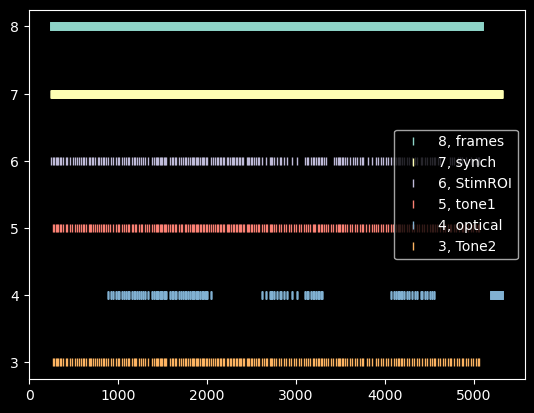

In [52]:
ch_name = ['8, frames', '7, synch', '6, StimROI','5, tone1', '4, optical', '3, Tone2']
i=0
for ch in ([8,7,6,5,4,3]):
    # plt.xlim(65,75)
    plt.plot(np.array(ni_ts[ch]),
             np.ones(len(ni_ts[ch]))*ch,
             '|',label=ch_name[i])

    i+=1
plt.legend()


In [53]:
# Convert the values to float
pellet_detected_frame = [float(frame) for frame in pellet_detected_frame]
pellet_delivery_frame = [float(frame) for frame in pellet_delivery_frame]


### Create a dictionary to store the data (this is the simple option)
- Run this cell if you want the nwb to have less data

In [57]:
stimuli_times_simple = { 'tone1_timestamps': tone1_timestamps,
                'tone2_timestamps': tone2_timestamps,
                'stimROI_timestamps': stimROI_timestamps,
                'frame_events_timestamp': frame_timestamps,
                'all_frames_sideCam_txt':frame_numbers,
                'frames_in_seconds_openEphys':frames_in_seconds_open_ephys,
                'optical_timestamps': optical_timestamps,

                  }

In [60]:
# Convert the 'frames' values to float
stimuli_times_simple['all_frames_sideCam_txt'] = [float(frame) for frame in stimuli_times_simple['all_frames_sideCam_txt']]


In [61]:

#stimulus list
stimuli = {'none': None,
           } 

## Assemble NWB

In [62]:
# !pip install pynwb
# !pip install numpy==1.24.3


In [63]:
import pynwb
from hdmf.backends.hdf5.h5_utils import H5DataIO
from hdmf.utils import StrDataset

In [64]:
from datetime import datetime
from dateutil.tz import tzlocal
from pynwb import NWBFile

print(experiment_description)

nwbfile = NWBFile(experiment_description, 
                  recording_folder, 
                  datetime.now(tzlocal()),
                  experimenter=experimenter,
                  lab='Christie Lab',
                  institution='University of Colorado Anschtuz Medical Campus',
                  experiment_description=experiment_description,
                  session_id=os.path.basename(recording_folder))

Christie Lab, University of Colorado Anschutz. Reaching  task with Pontine Gray mossy fiber stimulation to induce learning. Mouse used Reach7, was a Niave Mouse that could reach with ~80% success rate. recorded with 5 neuropixels (four NP1, and one NP2-4-shank in MoP ) from (SIM&IP, PG, MoP, VaL, SnR) with (probe_A, Probe_B, and Probe_C, Probe_D and Probe_E) respectively


### add stimulus information
- choose to run either the stimuli_times or stimuli_times_simple cell bellow (you can only run one, and that will decidce whats in your nwb)

In [65]:
# for stim in stimuli_times.keys():
#     nwbfile.add_epoch(np.array(stimuli_times[stim])[0], 
#                       np.array(stimuli_times[stim])[-1]+3.,
#                       [stim])

In [66]:
for stim in stimuli_times_simple.keys():
    nwbfile.add_epoch(np.array(stimuli_times_simple[stim])[0], 
                      np.array(stimuli_times_simple[stim])[-1]+3.,
                      [stim])

In [67]:
nwbfile

root pynwb.file.NWBFile at 0x2322126621136
Fields:
  epoch_tags: {
    all_frames_sideCam_txt,
    frame_events_timestamp,
    frames_in_seconds_openEphys,
    optical_timestamps,
    stimROI_timestamps,
    tone1_timestamps,
    tone2_timestamps
  }
  epochs: epochs <class 'pynwb.epoch.TimeIntervals'>
  experiment_description: Christie Lab, University of Colorado Anschutz. Reaching  task with Pontine Gray mossy fiber stimulation to induce learning. Mouse used Reach7, was a Niave Mouse that could reach with ~80% success rate. recorded with 5 neuropixels (four NP1, and one NP2-4-shank in MoP ) from (SIM&IP, PG, MoP, VaL, SnR) with (probe_A, Probe_B, and Probe_C, Probe_D and Probe_E) respectively
  experimenter: ['grh']
  file_create_date: [datetime.datetime(2025, 2, 3, 12, 25, 12, 651622, tzinfo=tzlocal())]
  identifier: G:\Grant\neuropixels\kilosort_recordings\reach7_07_2024-12-04_20-57-49_008
  institution: University of Colorado Anschtuz Medical Campus
  lab: Christie Lab
  session_d

## Run for stimuli_times 

In [68]:
### Uncomment for 

In [69]:
# nwbfile.add_trial_column('stimulus', 'the event occuring during this trial')
# #optogenetic pertibation
# nwbfile.add_trial_column('optogenetics_LED_state', 'whether or not the LED was on or off for this trial. 1=on,0=off. exact opto times are available in optogenetics_states field of NWB')
# #arbMatrix and scene flicker
# # nwbfile.add_trial_column('stimulus_index', 'index of each trial into a matrix or list of images')
# stim_vals = {'optogenetics_LED_state':-1,
       
# }
        
# stim = 'all_frames_sideCam_txt'
# for i,trial_start in enumerate(np.array(stimuli_times[stim])):
#     nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
#                      optogenetics_LED_state=0,

#                      )   
# stim = 'frames_in_seconds_openEphys'
# for i,trial_start in enumerate(np.array(stimuli_times[stim])):
#     nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
#                      optogenetics_LED_state=0,

#                      )
# stim = 'pellet_delivery_seconds_txt'
# for i,trial_start in enumerate(np.array(stimuli_times[stim])):
#     nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
#                      optogenetics_LED_state=0,

#                      )
# stim = 'pellet_detected_seconds_txt'
# for i,trial_start in enumerate(np.array(stimuli_times[stim])):
#     nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
#                      optogenetics_LED_state=0,

#                      )
# stim = 'pellet_delivery_slow_motion_txt'
# for i,trial_start in enumerate(np.array(stimuli_times[stim])):
#     nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
#                      optogenetics_LED_state=0,

#                      )
# stim = 'pellet_detected_slow_motion_txt'
# for i,trial_start in enumerate(np.array(stimuli_times[stim])):
#     nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
#                      optogenetics_LED_state=0,

#                      )
# stim = 'pellet_detected_timestamp'
# for i,trial_start in enumerate(np.array(stimuli_times[stim])):
#     nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
#                      optogenetics_LED_state=0,

#                      )
# stim = 'pellet_delivery_timestamp'
# for i,trial_start in enumerate(np.array(stimuli_times[stim])):
#     nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
#                      optogenetics_LED_state=0,

#                      )
# stim = 'frame_events_timestamp'
# for i,trial_start in enumerate(np.array(stimuli_times[stim])):
#     nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
#                      optogenetics_LED_state=0,

#                      )

    

## Run for stimuli_times_simple

In [71]:
len(tone1_timestamps), len(tone2_timestamps), len(frame_timestamps), len(frame_numbers), len(frames_in_seconds_open_ephys)

(219, 216, 727088, 726965, 727088)

In [72]:
nwbfile.add_trial_column('stimulus', 'the event occuring during this trial')

#optogenetic pertibation
nwbfile.add_trial_column('optogenetics_LED_state', 'whether or not the LED was on or off for this trial. 1=on,0=off. exact opto times are available in optogenetics_states field of NWB')


In [73]:

#arbMatrix and scene flicker
# nwbfile.add_trial_column('stimulus_index', 'index of each trial into a matrix or list of images')

stim_vals = {'optogenetics_LED_state':-1,
       
}


    
stim = 'tone1_timestamps'
for i, trial_start in enumerate(np.array(stimuli_times_simple[stim])):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start, stimulus=stim,
                    optogenetics_LED_state=0)
    
stim = 'tone2_timestamps'
for i,trial_start in enumerate(np.array(stimuli_times_simple[stim])):
    nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
                     optogenetics_LED_state=0,

                     )
    
stim = 'stimROI_timestamps'
for i,trial_start in enumerate(np.array(stimuli_times_simple[stim])):
    nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
                     optogenetics_LED_state=0,

                     )

stim = 'frame_events_timestamp'
total_trials = len(stimuli_times_simple[stim])
for i, trial_start in enumerate(np.array(stimuli_times_simple[stim])):
    nwbfile.add_trial(start_time=trial_start, stop_time=trial_start, stimulus=stim,
                      optogenetics_LED_state=0)


stim = 'optical_timestamps'
for i,trial_start in enumerate(np.array(stimuli_times_simple[stim])):
    nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
                     optogenetics_LED_state=0,)

#                      )
# print(f'here 2: {nwbfile.trials}')


# stim = 'all_frames_sideCam_txt'
# for i,trial_start in enumerate(np.array(stimuli_times_simple[stim])):
#     nwbfile.add_trial(start_time=trial_start,  stop_time=trial_start, stimulus=stim,
#                      optogenetics_LED_state=0,

#                      )   

## Check the trials dataframe

In [74]:
df = nwbfile.trials.to_dataframe()


In [59]:
df[0:5]

,0
0,2608
1,4819
2,7032
3,9282
4,11457


In [60]:

tone1_data = df[df['stimulus'] == 'tone1_timestamps']
tone2_data = df[df['stimulus'] == 'tone2_timestamps']
stimROI_data = df[df['stimulus'] == 'stimROI_timestamps']
pellet_delivery_slow_motion = df[df['stimulus'] == 'pellet_delivery_slow_motion_txt']
pellet_detected_slow_motion = df[df['stimulus'] == 'pellet_detected_slow_motion_txt']
all_frames_sideCam = df[df['stimulus'] == 'all_frames_sideCam_txt']
frames_in_seconds_openEphys = df[df['stimulus'] == 'frames_in_seconds_openEphys']
optical_timestamps = df[df['stimulus'] == 'optical_timestamps']


KeyError: 'stimulus'

In [77]:
tone1_data.head()

,start_time,stop_time,stimulus,optogenetics_LED_state
id,,,,
0,265.057246,265.057246,tone1_timestamps,0
1,279.803539,279.803539,tone1_timestamps,0
2,294.557752,294.557752,tone1_timestamps,0
3,309.560026,309.560026,tone1_timestamps,0
4,324.059259,324.059259,tone1_timestamps,0


In [78]:
tone2_data.head()

,start_time,stop_time,stimulus,optogenetics_LED_state
id,,,,
219,265.894271,265.894271,tone2_timestamps,0
220,280.396529,280.396529,tone2_timestamps,0
221,295.145770,295.145770,tone2_timestamps,0
222,310.155104,310.155104,tone2_timestamps,0
223,324.651276,324.651276,tone2_timestamps,0


In [79]:
stimROI_data.head()

,start_time,stop_time,stimulus,optogenetics_LED_state
id,,,,
435,247.710327,247.710327,stimROI_timestamps,0
436,266.478939,266.478939,stimROI_timestamps,0
437,280.673692,280.673692,stimROI_timestamps,0
438,295.975223,295.975223,stimROI_timestamps,0
439,310.123828,310.123828,stimROI_timestamps,0


In [80]:
all_frames_sideCam.head()

,start_time,stop_time,stimulus,optogenetics_LED_state
id,,,,


In [81]:
frames_in_seconds_openEphys.head()

,start_time,stop_time,stimulus,optogenetics_LED_state
id,,,,


In [82]:
optical_timestamps.head()

,start_time,stop_time,stimulus,optogenetics_LED_state
id,,,,
727723,884.348338,884.348338,optical_timestamps,0
727724,884.353338,884.353338,optical_timestamps,0
727725,884.358338,884.358338,optical_timestamps,0
727726,884.363339,884.363339,optical_timestamps,0
727727,884.368339,884.368339,optical_timestamps,0


## add optogenetics

In [61]:
optical_events.head()

,line,sample_number,timestamp,processor_id,stream_index,stream_name,state
108486,4,35389461,884.348338,102,9,PXIe-6341,1
108488,4,35389661,884.353338,102,9,PXIe-6341,0
108491,4,35389861,884.358338,102,9,PXIe-6341,1
108493,4,35390061,884.363339,102,9,PXIe-6341,0
108495,4,35390261,884.368339,102,9,PXIe-6341,1


In [65]:

# opto_on_times = delivery_pert_df['start_time'].to_numpy()
# opto_off_times = [value + 0.1 for value in opto_on_times]

# opto_on_times, opto_off_times


In [66]:
# frame_events 

# opto_off_times = detected_pert_df[camera_df.state==0].timestamp
# opto_on_times = camera_df[camera_df.state==1].timestamp

In [67]:
# opto_states = pynwb.epoch.TimeIntervals(
#     name="optogenetics_states",
#     description="intervals for optical fiber, fiber at power = ?? on what system. fiber 470nm, ",
# )

# opto_states.add_column(name="power", description="15mW")
# opto_states.add_column(name="wavelength", description="470nm")

# for i in range(np.array(opto_off_times).shape[0]):
#     opto_states.add_row(start_time=np.array(opto_on_times)[i], stop_time=np.array(opto_off_times)[i], power=1.5, wavelength=565)

# nwbfile.add_time_intervals(opto_states)

### add ephys data
first add electrodes and raw data link

In [68]:
# from dlab.nwbtools import df_from_phy, load_phy_template, option234_positions, multi_load_unit_data
from dlab.nwbtools import df_from_phy, load_phy_template, option234_positions # Removed multi_load_unit_data, outdates function


no Allen Institute NWB API. get this from http://stash.corp.alleninstitute.org/projects/INF/repos/ainwb/browse
no OpenEphys.py get this from https://github.com/open-ephys/analysis-tools


In [69]:
# df_units = multi_load_unit_data(recording_folder,probe_depths=probedepths)
# df_units.iloc[0]

#### This is setting the recording_folder to the correct location for the NWB
- recording_folder needs to include \Record Node 103\experiment1\recording1\continuous to work

In [70]:
recording_folder = root_recording_folder + r"\Record Node 103\experiment1\recording1\continuous"
print(recording_folder)

G:\Grant\neuropixels\kilosort_recordings\reach7_07_2024-12-04_20-57-49_008\Record Node 103\experiment1\recording1\continuous


##### The cell bellow needs to print contents for each probe like shown bellow
- Contents: ['Neuropix-PXI-100.ProbeA-AP', 'Neuropix-PXI-100.ProbeA-LFP', 'Neuropix-PXI-100.ProbeB-AP', 'Neuropix-PXI-100.ProbeB-LFP', 'Neuropix-PXI-100.ProbeC', 'Neuropix-PXI-100.ProbeD-AP', 'Neuropix-PXI-100.ProbeD-LFP', 'Neuropix-PXI-100.ProbeE-AP', 'Neuropix-PXI-100.ProbeE-LFP', 'NI-DAQmx-102.PXIe-6341']


In [71]:
import os

# recording_folder = r"G:\Grant\neuropixels\kilosort_recordings\reach3_01_2024-11-14_21-30-18_001\Record Node 103\experiment1\recording1\continuous"
print("Looking in:", recording_folder)
print("Contents:", os.listdir(recording_folder))

Looking in: G:\Grant\neuropixels\kilosort_recordings\reach7_07_2024-12-04_20-57-49_008\Record Node 103\experiment1\recording1\continuous
Contents: ['intermediates', 'Neuropix-PXI-100.ProbeA-AP', 'Neuropix-PXI-100.ProbeA-LFP', 'Neuropix-PXI-100.ProbeB-AP', 'Neuropix-PXI-100.ProbeB-LFP', 'Neuropix-PXI-100.ProbeC-AP', 'Neuropix-PXI-100.ProbeD-AP', 'Neuropix-PXI-100.ProbeD-LFP', 'Neuropix-PXI-100.ProbeE-AP', 'Neuropix-PXI-100.ProbeE-LFP', 'NI-DAQmx-102.PXIe-6341']


## Make layout for NP2-4-shank

In [78]:
import numpy as np

# Create empty array for 4-shank layout
positions = np.zeros((384, 2))

# Define constants
col_spacing = 32  # Column spacing in microns
row_spacing = 15  # Row spacing in microns
shank_spacing = 250  # Spacing between shanks in microns

# Shank 1: Channels 47–96
shank1_start_idx = 46
for i in range(25):  # 25 rows
    positions[shank1_start_idx + i, 0] = 0  # Column 1
    positions[shank1_start_idx + i, 1] = (i + 23) * row_spacing  # Row spacing
    positions[shank1_start_idx + i + 25, 0] = col_spacing  # Column 2
    positions[shank1_start_idx + i + 25, 1] = (i + 23) * row_spacing

# Shank 2: Channels 1–141
shank2_start_idx = 0
for i in range(71):  # 71 rows
    positions[shank2_start_idx + i, 0] = shank_spacing  # Column 1
    positions[shank2_start_idx + i, 1] = i * row_spacing
    positions[shank2_start_idx + i + 71, 0] = shank_spacing + col_spacing  # Column 2
    positions[shank2_start_idx + i + 71, 1] = i * row_spacing

# Shank 3: Channels 1–141 (same as Shank 2)
shank3_start_idx = 142
for i in range(71):  # 71 rows
    positions[shank3_start_idx + i, 0] = 2 * shank_spacing  # Column 1
    positions[shank3_start_idx + i, 1] = i * row_spacing
    positions[shank3_start_idx + i + 71, 0] = 2 * shank_spacing + col_spacing  # Column 2
    positions[shank3_start_idx + i + 71, 1] = i * row_spacing

# Shank 4: Channels 47–96 (same as Shank 1)
shank4_start_idx = 284
for i in range(25):  # 25 rows
    positions[shank4_start_idx + i, 0] = 3 * shank_spacing  # Column 1
    positions[shank4_start_idx + i, 1] = (i + 23) * row_spacing
    positions[shank4_start_idx + i + 25, 0] = 3 * shank_spacing + col_spacing  # Column 2
    positions[shank4_start_idx + i + 25, 1] = (i + 23) * row_spacing

positions[0:5]


array([[250.,   0.],
       [250.,  15.],
       [250.,  30.],
       [250.,  45.],
       [250.,  60.]])

#### Getting spike times if you had to use global_timestamps
- if you did not make global_timestamps.npy, ignore the commentewd out cells bellow 

In [79]:
# spike_times_path = r"G:\Grant\neuropixels\kilosort_recordings\reach3_01_2024-11-14_21-30-18_001\Record Node 103\experiment1\recording1\continuous\Neuropix-PXI-100.ProbeA-AP\global_timestamps.npy"
# spike_times = np.load(spike_times_path)
# spike_times.shape


### Verify these variables are correct. it is what will be used to make the NWB

In [83]:
print(probe_names)
print(NP_type)
print(probedepths)
recording_folder

['A', 'B', 'C', 'D', 'E']
['NP1', 'NP1', 'NP2', 'NP1', 'NP1']
[4156, 7013, 1450, 4878, 6202]


'G:\\Grant\\neuropixels\\kilosort_recordings\\reach7_07_2024-12-04_20-57-49_008\\Record Node 103\\experiment1\\recording1\\continuous'

## Creating df_units 
- uses new function `unit_data` from nwbtools to load all the units from the recording folder

In [82]:
from dlab.nwbtools import UnitData

# Initialize recording_path
recording_path = root_recording_folder 
recording_path = recording_path + '\\Record Node 103\\experiment1\\recording1'
recording_path

# Initialize UnitData
unit_data = UnitData(recording_path)
unit_data

# load unit data and create df_units
df_units = unit_data.load(probe_depths=probedepths, probes=probe_names, acq='OpenEphys', ignore_phy=False)
df_units


A
B
C
D
E


,cluster_id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh,probe,times,amplitudes,template,peak_wv,xpos,ypos
0,0,754.5,25.0,mua,65.201218,2,4116.0,3.080043,NaN,15632,0,A,"[244.2904666666668, 244.4332666666668, 244.833...","[12.416458129882812, 11.961356163024902, 10.61...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59.0,40.0
1,1,1115.6,4.4,good,87.563889,2,4116.0,2.342543,good,11889,0,A,"[251.6506000000002, 252.5949666666669, 252.710...","[18.557964324951172, 9.258334159851074, 9.6833...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59.0,40.0
2,2,3690.7,94.2,mua,125.804901,2,4116.0,0.129649,NaN,658,0,A,"[266.3581826589875, 266.52591598138804, 267.58...","[27.01292610168457, 34.93534469604492, 36.8380...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59.0,40.0
3,3,1138.3,390.0,mua,69.682053,2,4116.0,0.014186,NaN,72,0,A,"[328.9849333333445, 464.8765666666686, 534.949...","[14.95019245147705, 13.834561347961426, 15.620...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59.0,40.0
4,4,1137.4,69.8,mua,85.957153,6,4076.0,0.682133,NaN,3462,0,A,"[252.5823333333334, 252.71266666666685, 255.85...","[14.769704818725586, 11.293598175048828, 13.00...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923,248,575.3,0.0,good,36.137901,119,5002.0,0.052805,NaN,268,0,E,"[2957.6609303734053, 2957.669263750684, 2957.7...","[15.195669174194336, 15.080528259277344, 15.12...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",27.0,1200.0
1924,249,2522.0,98.6,mua,77.490944,111,5082.0,0.546968,NaN,2776,0,E,"[2922.601464942398, 2922.721498893243, 2923.23...","[43.68961715698242, 24.469383239746094, 44.680...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",27.0,1120.0
1925,250,1426.0,80.5,mua,45.453018,111,5082.0,0.109748,NaN,557,0,E,"[2922.3016105748843, 2922.6697319602677, 2922....","[19.14520263671875, 50.31452560424805, 19.8196...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",27.0,1120.0
1926,251,2951.7,53.5,mua,50.888058,111,5082.0,0.064036,NaN,325,0,E,"[2922.6016316099212, 2922.6715653030506, 2922....","[43.6500358581543, 39.60683822631836, 30.27145...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",27.0,1120.0


### This will check if this unit_data function from nwbtools can find you data
- need to uncomment the cell to use it
- its a copy from the nwbtools code, and will print out the data it finds

In [84]:
# recording_path = recording_path
# all_folders    = glob.glob(os.path.join(recording_path,'continuous','*'))
# ap_folders     = [folder for folder in all_folders if 'LFP' not in os.path.basename(folder)]
# print(all_folders)

# for i,PROBE in enumerate(probe_names):
#             print(PROBE)
#             probe_name = PROBE
#             print(probe_name)
#             for folder in ap_folders:
#                 print(folder)
#                 if 'Probe'+PROBE in folder:
#                     probe_path = folder
            
#             os.chdir(probe_path)

### save out the df_units as a json
- creates the intermediate folder if it does not exist
- saves the df_units as a json file into that folder


In [100]:
int_path

'G:\\Grant\\neuropixels\\kilosort_recordings\\reach7_07_2024-12-04_20-57-49_008\\Record Node 103\\experiment1\\recording1\\continuous\\intermediates'

In [92]:
int_path = os.path.join(recording_folder,'intermediates')
df_units_json_path = int_path + '\\df_units.json'


if os.path.exists(df_units_json_path):
    print('df_units.json already exists')
else:
    if not os.path.exists(int_path):
        os.makedirs(int_path)
    df_units.to_json(df_units_json_path)
    print('df_units.json saved')


df_units.json already exists


#### Check if the df_units.json file is saved

In [93]:
df_units_json = pd.read_json(df_units_json_path)
df_units_json.head()

,cluster_id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh,probe,times,amplitudes,template,peak_wv,xpos,ypos
0,0,754.5,25.0,mua,65.201218,2,4116,3.080043,None,15632,0,A,"[244.2904666667, 244.4332666667, 244.833, 244....","[12.4164581299, 11.961356163, 10.6130752563, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59,40
1,1,1115.6,4.4,good,87.563889,2,4116,2.342543,good,11889,0,A,"[251.6506, 252.5949666667, 252.7104666667, 252...","[18.557964325, 9.2583341599, 9.6833286285, 13....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59,40
2,2,3690.7,94.2,mua,125.804901,2,4116,0.129649,None,658,0,A,"[266.358182659, 266.5259159814, 267.5848825791...","[27.0129261017, 34.935344696, 36.8380126953, 3...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59,40
3,3,1138.3,390.0,mua,69.682053,2,4116,0.014186,None,72,0,A,"[328.9849333333, 464.8765666667, 534.9493, 584...","[14.9501924515, 13.834561348, 15.620092392, 12...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59,40
4,4,1137.4,69.8,mua,85.957153,6,4076,0.682133,None,3462,0,A,"[252.5823333333, 252.7126666667, 255.8557, 255...","[14.7697048187, 11.293598175, 13.0035667419, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59,80


### Save out the df_stim 
- this is the df for all the stimuli and their timestamps
- initally made as just df earielr in this notebook
- before making the NWB

In [234]:
df.head()

,start_time,stop_time,stimulus,optogenetics_LED_state
id,,,,
0,265.057246,265.057246,tone1_timestamps,0
1,279.803539,279.803539,tone1_timestamps,0
2,294.557752,294.557752,tone1_timestamps,0
3,309.560026,309.560026,tone1_timestamps,0
4,324.059259,324.059259,tone1_timestamps,0


In [95]:
int_path = os.path.join(recording_folder,'intermediates')
df_stim_path = int_path + '\\df_stim.json'
   
if os.path.exists(df_stim_path):
    print('df_stim.json already exists')
else:
    if not os.path.exists(int_path):
        os.makedirs(int_path)
    df.to_json(df_stim_path)
    print('df_stim.json saved')

df_stim.json already exists


#### check if the file was saved

In [96]:
df_stim_json = pd.read_json(df_stim_path)
df_stim_json.head()

,0
0,2608
1,4819
10,30875
100,303013
101,306320


### This will check the df_units dataframe before it goes through the next conversion step
- the conversion step turn "Good" units into the value 2
- the conversion step turns "MUA" units into the value 1


In [97]:
dfA = df_units[df_units.probe=='A'][df_units.KSLabel=='good'] # these are the "good" labelled units from phy before curation
dfB = df_units[df_units.probe=='B'][df_units.KSLabel=='good'] # these are the "good" labelled units from phy before curation
dfC = df_units[df_units.probe=='C'][df_units.KSLabel=='good'] # these are the "good" labelled units from phy before curation
dfD = df_units[df_units.probe=='D'][df_units.KSLabel=='good'] # these are the "good" labelled units from phy before curation
dfE = df_units[df_units.probe=='E'][df_units.KSLabel=='good'] # these are the "good" labelled units from phy before curation

print(f'Good units in probe A: {len(dfA)} --> SIM & IP')
print(f'Good units in probe B: {len(dfB)} --> PG')
print(f'Good units in probe C: {len(dfC)} --> Mop')
print(f'Good units in probe D: {len(dfD)} --> VaL')
print(f'Good units in probe E: {len(dfE)} --> SnR')


Good units in probe A: 211 --> SIM & IP
Good units in probe B: 4 --> PG
Good units in probe C: 22 --> Mop
Good units in probe D: 385 --> VaL
Good units in probe E: 9 --> SnR


C:\Users\user\AppData\Local\Temp\ipykernel_24232\4034743827.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfA = df_units[df_units.probe=='A'][df_units.KSLabel=='good'] # these are the "good" labelled units from phy before curation
C:\Users\user\AppData\Local\Temp\ipykernel_24232\4034743827.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfB = df_units[df_units.probe=='B'][df_units.KSLabel=='good'] # these are the "good" labelled units from phy before curation
C:\Users\user\AppData\Local\Temp\ipykernel_24232\4034743827.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfC = df_units[df_units.probe=='C'][df_units.KSLabel=='good'] # these are the "good" labelled units from phy before curation
C:\Users\user\AppData\Local\Temp\ipykernel_24232\4034743827.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfD = df_units[df_units.probe=='D'][df_units.KSLa

In [98]:
dfA_bad = df_units[df_units.probe=='A'][df_units.KSLabel=='mua'] # these are the "good" labelled units from phy before curation
dfB_bad = df_units[df_units.probe=='B'][df_units.KSLabel=='mua'] # these are the "good" labelled units from phy before curation
dfC_bad = df_units[df_units.probe=='C'][df_units.KSLabel=='mua'] # these are the "good" labelled units from phy before curation
dfD_bad = df_units[df_units.probe=='D'][df_units.KSLabel=='mua'] # these are the "good" labelled units from phy before curation
dfE_bad = df_units[df_units.probe=='E'][df_units.KSLabel=='mua'] # these are the "good" labelled units from phy before curation

print(f'MUA units in probe A: {len(dfA_bad)} --> SIM & IP')
print(f'MUA units in probe B: {len(dfB_bad)} --> PG')
print(f'MUA units in probe C: {len(dfC_bad)} --> Mop')
print(f'MUA units in probe D: {len(dfD_bad)} --> VaL')
print(f'MUA units in probe E: {len(dfE_bad)} --> SnR')

MUA units in probe A: 336 --> SIM & IP
MUA units in probe B: 229 --> PG
MUA units in probe C: 97 --> Mop
MUA units in probe D: 391 --> VaL
MUA units in probe E: 244 --> SnR


C:\Users\user\AppData\Local\Temp\ipykernel_24232\4005783470.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfA_bad = df_units[df_units.probe=='A'][df_units.KSLabel=='mua'] # these are the "good" labelled units from phy before curation
C:\Users\user\AppData\Local\Temp\ipykernel_24232\4005783470.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfB_bad = df_units[df_units.probe=='B'][df_units.KSLabel=='mua'] # these are the "good" labelled units from phy before curation
C:\Users\user\AppData\Local\Temp\ipykernel_24232\4005783470.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfC_bad = df_units[df_units.probe=='C'][df_units.KSLabel=='mua'] # these are the "good" labelled units from phy before curation
C:\Users\user\AppData\Local\Temp\ipykernel_24232\4005783470.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfD_bad = df_units[df_units.probe=='D'][

In [36]:
dfA_bad = df_units[df_units.probe=='A'][df_units.KSlabel==1] # these are the "good" labelled units from phy before curation
dfB_bad = df_units[df_units.probe=='B'][df_units.KSlabel==1] # these are the "good" labelled units from phy before curation
dfC_bad = df_units[df_units.probe=='C'][df_units.KSlabel==1] # these are the "good" labelled units from phy before curation
dfD_bad = df_units[df_units.probe=='D'][df_units.KSlabel==1] # these are the "good" labelled units from phy before curation
dfE_bad = df_units[df_units.probe=='E'][df_units.KSlabel==1] # these are the "good" labelled units from phy before curation

print(f'MUA units in probe A: {len(dfA_bad)} --> SIM & IP')
print(f'MUA units in probe B: {len(dfB_bad)} --> PG')
print(f'MUA units in probe C: {len(dfC_bad)} --> Mop')
print(f'MUA units in probe D: {len(dfD_bad)} --> VaL')
print(f'MUA units in probe E: {len(dfE_bad)} --> SnR')


MUA units in probe A: 336 --> SIM & IP
MUA units in probe B: 229 --> PG
MUA units in probe C: 97 --> Mop
MUA units in probe D: 391 --> VaL
MUA units in probe E: 244 --> SnR


C:\Users\user\AppData\Local\Temp\ipykernel_28640\3665535943.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfA_bad = df_units[df_units.probe=='A'][df_units.KSlabel==1] # these are the "good" labelled units from phy before curation
C:\Users\user\AppData\Local\Temp\ipykernel_28640\3665535943.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfB_bad = df_units[df_units.probe=='B'][df_units.KSlabel==1] # these are the "good" labelled units from phy before curation
C:\Users\user\AppData\Local\Temp\ipykernel_28640\3665535943.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfC_bad = df_units[df_units.probe=='C'][df_units.KSlabel==1] # these are the "good" labelled units from phy before curation
C:\Users\user\AppData\Local\Temp\ipykernel_28640\3665535943.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfD_bad = df_units[df_units.probe=='D'][df_units.KSl